In [49]:
%matplotlib inline
import pysal as ps
import numpy as np
import pandas as pd
import descartes
import geopandas as gp
import shapely
import copy
import random
import os
import sys
#import acs_regionalization as ACS
import matplotlib.pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 30,30
rcParams['patch.linewidth'] = 1.0  #set default polygon line width
rcParams['patch.force_edgecolor'] = True
rcParams['patch.edgecolor'] = 'b'

[]

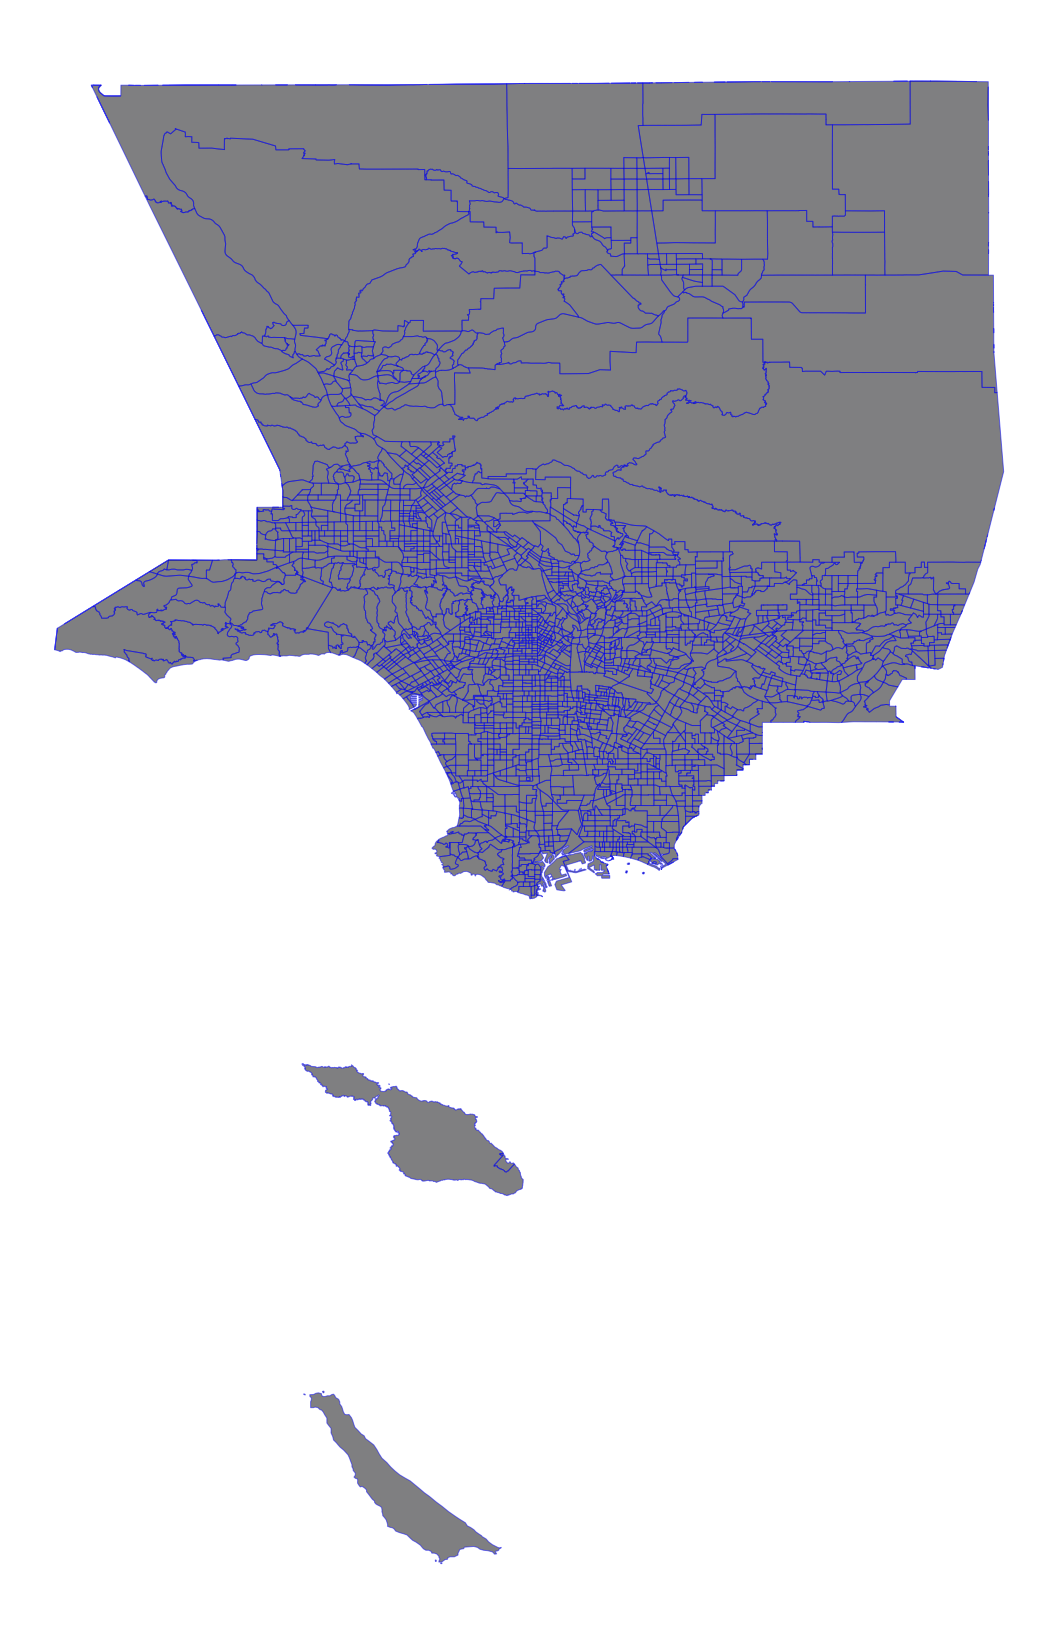

In [51]:
shp_map = gp.read_file('LAC_ZERO_MOE_1.shp')
shp_map['constant'] = 1
p = shp_map.plot('constant', alpha=0.50, cmap='inferno')
p.axis('off')
p.plot()

In [25]:
w = ps.rook_from_shapefile('LAC_ZERO_MOE_1.shp', idVariable='GEOID')
print(w.n)

2393


Text(0, 0.5, 'number of tracts')

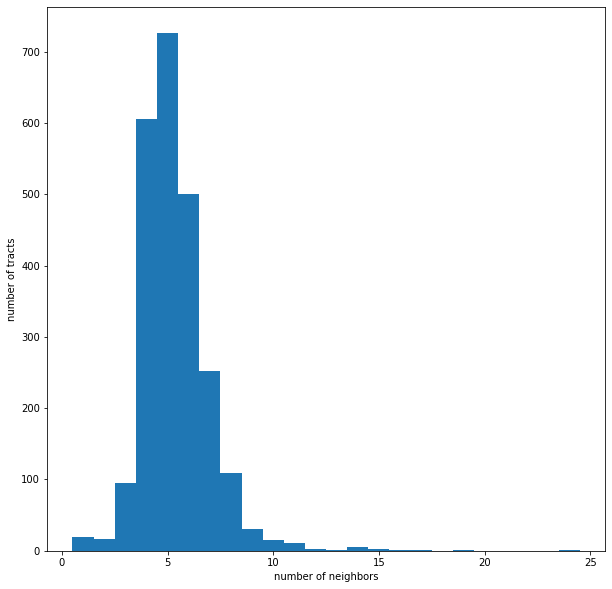

In [27]:
# summary of the connectivity structure of the Los Angeles County census tracts
w_hist_data = np.array(w.histogram)
fig, ax = plt.subplots(figsize=(10,10))
ax.bar(w_hist_data[:,0], w_hist_data[:,1], align='center', width=1)
ax.set_xlabel('number of neighbors')
ax.set_ylabel('number of tracts')

In [ ]:
# read in list of census tracts to exclude
# using arcmap to view zoning data overlaid on census tracts symbolized by total population estimate per tract
# exclude = open('excluded_lacounty.csv')
# exclude = exclude.readline()
# exclude = exclude.replace('g','')
# exclude = exclude.split(',')
# print exclude

In [ ]:
# read in the ACS estimates and standard errors
population = pd.read_csv('lacounty_population_estimates.csv', index_col=0)

est_vet_pop = pd.read_csv('lac_est_vet_pop.csv', index_col=0)
stderr_pop = pd.read_csv('stdErr_lactracts.csv', index_col=0)
moe_pop = stderr_pop * 1.65  # changed from 1.645 to 1.65 to reduce decimal places in analysis
pop_tract_ids = open('pop_tracts.csv')
pop_tract_ids = pop_names.readline().split(',')

est_ratio = pd.read_csv('lac_est_vet_pop.csv', index_col=0)
std_ratio = pd.read_csv('stdErr_lactracts.csv', index_col=0)
moe_ratio = stderr_pop * 1.65  # changed from 1.645 to 1.65 to reduce decimal places in analysis
ratio_names = open('population_ratio.csv')
ratio_names = ratio_names.readline().split(',')

In [ ]:
# ratio and population data is organized as numerator-denominator pairs
print ratio_names
print est_ratio.columns  # names of the numerators and denominators
print '\nthe numerator of %s is %s, and the denominator is %s'%(ratio_names[1], est_ratio.columns[2], est_ratio.columns[3])
print 'the numerator of %s is %s, and the denominator is %s'%(prop_names[0], est_prop.columns[0], est_prop.columns[1])

In [ ]:
# this may take up to four minutes to run depending on hardware speed
shp = ps.open(''LAC_ZERO_MOE_1.shp')
random.seed(745)     # to ensure we get the same solution each time
np.random.seed(745)  # to ensure we get the same solution each time
results = ACS.ACS_Regions(w=w,\
                          target_est_vet_pop=est_vet_pop.values,\
                          target_moe_pop=moe_pop.values,\
                          target_est_ratio=est_ratio.values,\
                          target_moe_ratio=moe_ratio.values,\
                          count_est=population.values,\
                          target_th_all=0.05,\
                          exclude=exclude,\
                          compactness=shp,\
                          cv_exclude_pop=0.05)
print 'regionalization finished'

In [ ]:
# some basic diagnostics on the solution
print 'number of regions:', len(results.regions)
print 'total time (seconds):', results.time['total']

In [ ]:
# This is a python function to create the side by side plots of LA County

# We'll make a few side-by-side plots. This code wraps the setup into a function. This will plot out the two maps
# of LA County before and after regionalization.
def two_plot_setup():
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(40,40))
    axes[0].set_aspect('equal')
    axes[1].set_aspect('equal')
    axes[0].axis('off')
    axes[1].axis('off')
    return fig, axes

In [ ]:
#This cell calls the above function and actually creates the two plots.

fig, axes = two_plot_setup()

# color tracts based on region ID  #This shows all the tracts [before]
rids = copy.copy(results.region_ids)
shp_map['rids'] = rids
shp_map.plot('rids', categorical=True, alpha=1, colormap='Dark2', axes=axes[0])

# disolve the tracts into regions  [after]
region_groups = shp_map.groupby('rids')
region_map = gp.GeoDataFrame(index=region_groups.indices.keys())
region_map['rids'] = region_groups.indices.keys()
region_map['geometry'] = region_groups.geometry.apply(shapely.ops.unary_union)
region_map.plot('rids', categorical=True, alpha=1, colormap='Dark2', axes=axes[1])